# Overview

Perform NLP on COVID-19 research papers to extract useful information.

1. Exploratory Data Analysis (EDA)
    - Find most common words and bigrams in title
    - Topic modelling using Latent Dirichlet Allocation (LDA) and gensim, visualize with pyLDAvis
    
2. Find similar papers
    - Get embeddings using Universal Sentence Encoder (USE) and find similar titles using cosine similarity
    
3. Find papers matching query
    - Using cosine similarity & similarity matrix of embeddings

4. Keyword extraction
    - Extact keywords from abstracts using Rake

5. Knowledge graphs
    - Entity detection, dependency parsing, and knowledge graphs from paper abstracts

In [1]:
!pip install rake-nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.7 which is incompatible.


### Imports

In [2]:
# Core
import pandas as pd
import numpy as np
import os
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('omw-1.4')
import spacy
from spacy.matcher import Matcher 
import tensorflow_hub as hub
from rake_nltk import Rake
import gensim
import pyLDAvis, pyLDAvis.gensim
import networkx as nx

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


## Exploratory Data Analysis

In [3]:
# Load data
df_cord=pd.read_csv("../input/covid-medical-paper-summarization-dataset/biorxiv_clean.csv")
df_cord.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,bbf09194127619f57b3ddf5daf684593a5831367,The Effectiveness of Targeted Quarantine for M...,"Alastair Jamieson-Lane, Eric Cytrnbaum",Alastair Jamieson-Lane (Carl von Ossietzky Uni...,Abstract\n\nWe model the extent to which age t...,"Introduction\n\nCOVID-19, initially observed/d...",Impact of non-pharmaceutical interventions (NP...,"[{'first': 'Alastair', 'middle': [], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Impact ..."
1,2a21fdd15e07c89c88e8c2f6c6ab5692568876ec,Evaluation of Group Testing for SARS-CoV-2 RNA,"Nasa Sinnott-Armstrong, Daniel L Klein, Brenda...","Nasa Sinnott-Armstrong, Daniel L Klein, Brenda...",Abstract\n\nDuring the current COVID-19 pandem...,Introduction\n\nGroup testing was first descri...,"In one Italian town, we showed mass testing co...","[{'first': 'Nasa', 'middle': [], 'last': 'Sinn...","{'BIBREF0': {'ref_id': 'b0', 'title': 'In one ..."
2,e686d1ce1540026ecb100c09f99ed091c139b92c,Why estimating population-based case fatality ...,"Lucas Böttcher, Mingtao Xia, Tom Chou","Lucas Böttcher, Mingtao Xia (UCLA, 90095-1555,...",Abstract\n\nDifferent ways of calculating mort...,\n\nDifferent ways of calculating mortality ra...,"COVID-19 statistics, , , None; The Lancet, Z X...","[{'first': 'Lucas', 'middle': [], 'last': 'Böt...","{'BIBREF2': {'ref_id': 'b2', 'title': 'COVID-1..."
3,c6039f8933305c9f44a44c81a15b321b6c2848dc,Far-UVC light: A new tool to control the sprea...,"David Welch, Manuela Buonanno, Veljko Grilj, I...",David Welch (Columbia University Medical Cente...,Abstract\n\nAirborne-mediated microbial diseas...,3\n\nAirborne-mediated microbial diseases repr...,"Global, regional, and national life expectancy...","[{'first': 'David', 'middle': [], 'last': 'Wel...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Global,..."
4,073d74442e2655d79b0b3f764a627ec667ad422c,Quantifying SARS-CoV-2 transmission suggests e...,"Luca Ferretti, Chris Wymant, Michelle Kendall,...","Luca Ferretti (University of Oxford, Oxford, U...",Abstract\n\nThe newly emergent human virus SAR...,IV.\n\nEnvironmental transmission: transmissio...,"Early Transmission Dynamics in Wuhan, China, o...","[{'first': 'Luca', 'middle': [], 'last': 'Ferr...","{'BIBREF2': {'ref_id': 'b2', 'title': 'Early T..."


In [4]:
df_cord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625 entries, 0 to 1624
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          1625 non-null   object
 1   title             1562 non-null   object
 2   authors           1586 non-null   object
 3   affiliations      1586 non-null   object
 4   abstract          1410 non-null   object
 5   text              1625 non-null   object
 6   bibliography      1625 non-null   object
 7   raw_authors       1625 non-null   object
 8   raw_bibliography  1625 non-null   object
dtypes: object(9)
memory usage: 114.4+ KB


In [5]:
# Create corpus from tokenizing paper titles
def get_titles_corpus(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    stop=set(stopwords.words('english'))
    for news in df['title'].dropna()[:5000]:
        # remove stopwords
        words=[w for w in word_tokenize(news) if (w not in stop)]
        # lemmatize
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = get_titles_corpus(df_cord)

In [6]:
# Get most common ngrams from corpus
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

### Most common words in title

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

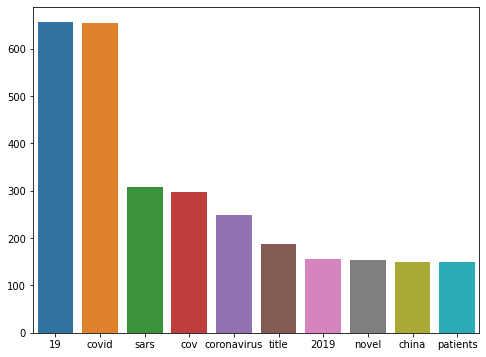

In [7]:
top_n_words=get_top_ngram(df_cord['title'].dropna(),1)[:10]
x,y=map(list,zip(*top_n_words))
plt.figure(figsize=(8, 6))
sns.barplot(x, y)

### Most common bigrams in title

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

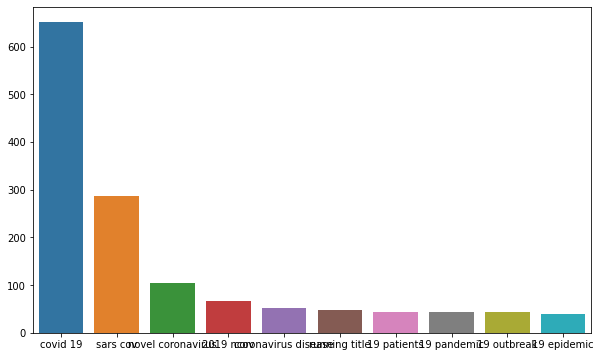

In [8]:
top_n_bigrams=get_top_ngram(df_cord['title'].dropna(),2)[:10]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(10, 6))
sns.barplot(x, y)

# Clear memory
del x, y, top_n_words, top_n_bigrams
gc.collect()

### Topic modeling from titles

In [9]:
# Create bag-of-words (BoW) vector from corpus
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [10]:
# Build LDA model
lda_model =  gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2)

In [11]:
lda_model.show_topics()

[(0,
  '0.045*"COVID-19" + 0.015*"China" + 0.010*"epidemic" + 0.010*"coronavirus" + 0.010*"patient" + 0.008*"Title" + 0.008*"Wuhan" + 0.007*"outbreak" + 0.007*"study" + 0.007*"The"'),
 (1,
  '0.026*"COVID-19" + 0.019*"SARS-CoV-2" + 0.010*"Coronavirus" + 0.008*"coronavirus" + 0.007*"protein" + 0.006*"2019" + 0.005*"Novel" + 0.005*"virus" + 0.005*"RNA" + 0.005*"Clinical"'),
 (2,
  '0.015*"SARS-CoV-2" + 0.012*"COVID-19" + 0.006*"Title" + 0.006*"cell" + 0.005*"2019-nCoV" + 0.004*"model" + 0.004*"The" + 0.004*"data" + 0.004*"transmission" + 0.003*"using"'),
 (3,
  '0.019*"COVID-19" + 0.009*"SARS-CoV-2" + 0.006*"virus" + 0.005*"Title" + 0.005*"The" + 0.005*"Outbreak" + 0.004*"infection" + 0.004*"influenza" + 0.004*"analysis" + 0.004*"host"')]

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.122655 -0.024034       1        1  34.656991
1     -0.015676  0.112308       2        1  31.098487
3     -0.054426 -0.037076       3        1  18.548879
2     -0.052553 -0.051197       4        1  15.695643, topic_info=            Term        Freq       Total Category  logprob  loglift
10    SARS-CoV-2  180.000000  180.000000  Default  30.0000  30.0000
61         Wuhan   51.000000   51.000000  Default  29.0000  29.0000
14      epidemic   80.000000   80.000000  Default  28.0000  28.0000
147        China  117.000000  117.000000  Default  27.0000  27.0000
179     Outbreak   20.000000   20.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
614        title    5.501382   31.352130   Topic4  -6.1319   0.1115
39       patient    7.061520   89.847552   Topic4  -5.8822  -0.6917
38   coronavirus    6.548573  112.352929   Topic4  -5.9576  -0.9906
239     outbreak    5.704672   62.372783   Topic4  -6.0956  -0.5401
147        China    5.418291  117.308827   Topic4  -6.1471  -1.2232

[314 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
233       1  0.466911       2019
233       2  0.451347       2019
233       3  0.015564       2019
233       4  0.062255       2019
400       1  0.493894  2019-nCoV
...     ...       ...        ...
177       2  0.350350      virus
177       3  0.256025      virus
177       4  0.067375      virus
831       1  0.830072     within
416       3  0.848546   zoonotic

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

# Clear memory
del corpus,lda_model,bow_corpus
gc.collect()

## Find Similar Papers

In [13]:
# Helper function to get similar sentences from similarity matrix
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    index = sentence_list.index(sentence)
    similarity_row = np.array(similarity_matrix[index, :])
    indices = similarity_row.argsort()[-topN:][::-1]
    return [(i,sentence_list[i]) for i in indices]

### Using Universal sentence Encoder and cosine similarity.

In [14]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/4')

2022-05-06 13:43:19.774208: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
# Create embeddings and similarity matrix
titles=df_cord['title'].fillna("Unknown")
embed_vectors=embed(titles[:100].values)['outputs'].numpy()
sentence_list=titles.values.tolist()
sentence=titles.iloc[5]
print("Find similar research papers for :")
print(sentence)

similarity_matrix=cosine_similarity(embed_vectors)
similar=get_top_similar(sentence,sentence_list,similarity_matrix,6)

2022-05-06 13:43:31.042862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Find similar research papers for :
Title: First 12 patients with coronavirus disease


In [16]:
for sentence in similar:
    print(sentence)
    print("\n")

(5, 'Title: First 12 patients with coronavirus disease')


(93, 'TITLE PAGE Manuscript title: Cross-reaction of sera from COVID-19 patients with SARS-CoV assays')


(35, 'Title: Analyzing Vaccine Trials in Epidemics with Mild and Asymptomatic Infection')


(48, 'Sex differences in clinical findings among patients with coronavirus disease 2019 (COVID-19) and severe condition')


(90, 'Title: Ancient RNA virus epidemics through the lens of recent adaptation in human genomes 1 2')


(73, 'Title Non-invasive surveys of mammalian viruses using environmental DNA')




del embed_vectors,sentence_list,similarity_matrix
gc.collect()

## Finding related papers from query

### What is known about transmission, incubation, and environmental stability?

- Seasonality of transmission.
- Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
- Natural history of the virus and shedding of it from an infected person
- Implementation of diagnostics and products to improve clinical processes
- Disease models, including animal models for infection, disease and transmission
- Tools and studies to monitor phenotypic change and potential adaptation of the virus
- Immune response and immunity
- Role of the environment in transmission

In [17]:
# Define taks
tasks=["What is known about transmission, incubation, and environmental stability",
      "What do we know about COVID-19 risk factors",
      "What do we know about virus genetics, origin, and evolution",
      "What do we know about vaccines and therapeutics",
      "What do we know about non-pharmaceutical interventions",
      "What do we know about diagnostics and surveillance",
      "What has been published about ethical and social science considerations",
      "Role of the environment in transmission",
      "Range of incubation periods for the disease in humans",
      "Prevalence of asymptomatic shedding and transmission",
      "Seasonality of transmission",
      "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)",
      "Susceptibility of populations",
      "Public health mitigation measures that could be effective for control",
      "Transmission dynamics of the virus",
      "Evidence that livestock could be infected",
      "Socioeconomic and behavioral risk factors for this spill-over",
      "Sustainable risk reduction strategies",
      "Resources to support skilled nursing facilities and long term care facilities",
      "Mobilization of surge medical staff to address shortages in overwhelmed communities"]

In [18]:
df_tasks=pd.DataFrame({'title':tasks,'source':'task'})
df_tasks.head()

,title,source
0,"What is known about transmission, incubation, ...",task
1,What do we know about COVID-19 risk factors,task
2,"What do we know about virus genetics, origin, ...",task
3,What do we know about vaccines and therapeutics,task
4,What do we know about non-pharmaceutical inter...,task


In [19]:
df_cord=pd.concat([df_cord,df_tasks])
df_cord.fillna("Unknown",inplace=True)

### Find related research papers using USE 

In [20]:
sentence_list=df_cord.title.values.tolist()
embed_vectors=embed(sentence_list)['outputs'].numpy()
similarity_matrix=cosine_similarity(embed_vectors)

In [21]:
sentence= "Role of the environment in transmission"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,10)
for sent in similar:
    print(sent[1])

Role of the environment in transmission
Effects of temperature on COVID-19 transmission
What is known about transmission, incubation, and environmental stability
The role of absolute humidity on transmission rates of the COVID-19 outbreak
Transmission dynamics of the virus
Temperature dependence of COVID-19 transmission
Roles of meteorological conditions in COVID-19 transmission on a worldwide scale
Seasonality of transmission
Transmission Dynamics of 2019-nCoV in Malaysia
Cryptic transmission of SARS-CoV-2 in Washington State


- Clean and store abstracts from related articles.

In [22]:
ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(df_cord.iloc[i]['title'])
    texts.append(df_cord.iloc[i]['abstract'])

In [23]:
import re
def clean(txt):
    txt=re.sub(r'\n','',txt)
    txt=re.sub(r'\([^()]*\)','',txt)
    txt=re.sub(r'https?:\S+\sdoi','',txt)
    return txt

In [24]:
texts=list(map(clean,texts))
text_list=' '.join(texts)
#text_list=word_tokenize(text_list)

## Keyword Extraction

Keyword extraction is the automated process of extracting the most relevant words and expressions from text.Keyword extraction (also known as keyword detection or keyword analysis) is a text analysis technique that consists of automatically extracting the most important words and expressions in a text. It helps summarize the content of a text and recognize the main topics which are being discussed. 

In [25]:
r = Rake()
r.extract_keywords_from_text(text_list)
r.get_ranked_phrases()

['data available unknown unknown unknown abstractthe recent coronavirus pandemic follows',
 'relative humidity combined together could best predict',
 'around 10000 units per 15 minutes',
 'severe acute respiratory syndrome coronavirus 2',
 'meteorological model could well predict',
 'unknown abstractthis paper focuses',
 'abstractthe novel coronavirus identified',
 'time reasonably well fit',
 'unknown abstractcoronavirus disease 2019',
 'n ∝ e αt',
 'recent novel coronavirus',
 'four different time delays',
 'next confirmed case given',
 'weather two weeks ago',
 '56 ° c kills',
 'observed amongst chinese patients',
 'e ., air temperature',
 '20 coronavirus pandemic',
 'via respiratory droplets',
 'model could provide',
 'confirmed case counts',
 'next cold season',
 'single case introduced',
 'relative humidity',
 'rather homogeneous way',
 'mediated viral diseases',
 'known human coronaviruses',
 'four meteorological variables',
 'findings give hope',
 'caused great damage',
 'almo

## Knowledge Graph

In [26]:
nlp=spacy.load('en_core_web_sm')

In [27]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

  #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                   prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              modifier = prv_tok_text + " "+ tok.text

          ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

          ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
  #############################################################

    return [ent1.strip(), ent2.strip()]

In [28]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

#### Question : What is the Role of the environment in transmission?

- We will prepare a dataframe that contains,subject,relation and object from these abstracts to plot the knowledge graph.


In [29]:
def prepare_df(text_list):
    doc=nlp(text_list)
    df=pd.DataFrame()
    for sent in list(doc.sents):
        sub,obj = get_entities(str(sent))
        relation= get_relation(str(sent))

        if ((len(relation)>2) & (len(sub)>2) &(len(obj)>2)):
            df=df.append({'subject':sub,'relation':relation,'object':obj},ignore_index=True)

    return df

In [30]:
df = prepare_df(text_list[24:])
df.head()

,subject,relation,object
0,2 syndrome it,identified in,2019 coronavirus pandemic
1,"79,968 patients",observed amongst Chinese,Chinese mortality patients
2,primary mode,is via respiratory,respiratory coughs
3,virus,remain viable,human coronaviruses
4,56 C,kills,15 SARS minutes


In [31]:
def draw_kg(pairs,c1='red',c2='blue',c3='orange'):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
  
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(50, 40), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color=c1,
        edgecolors=c2,
        node_color=c3,
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

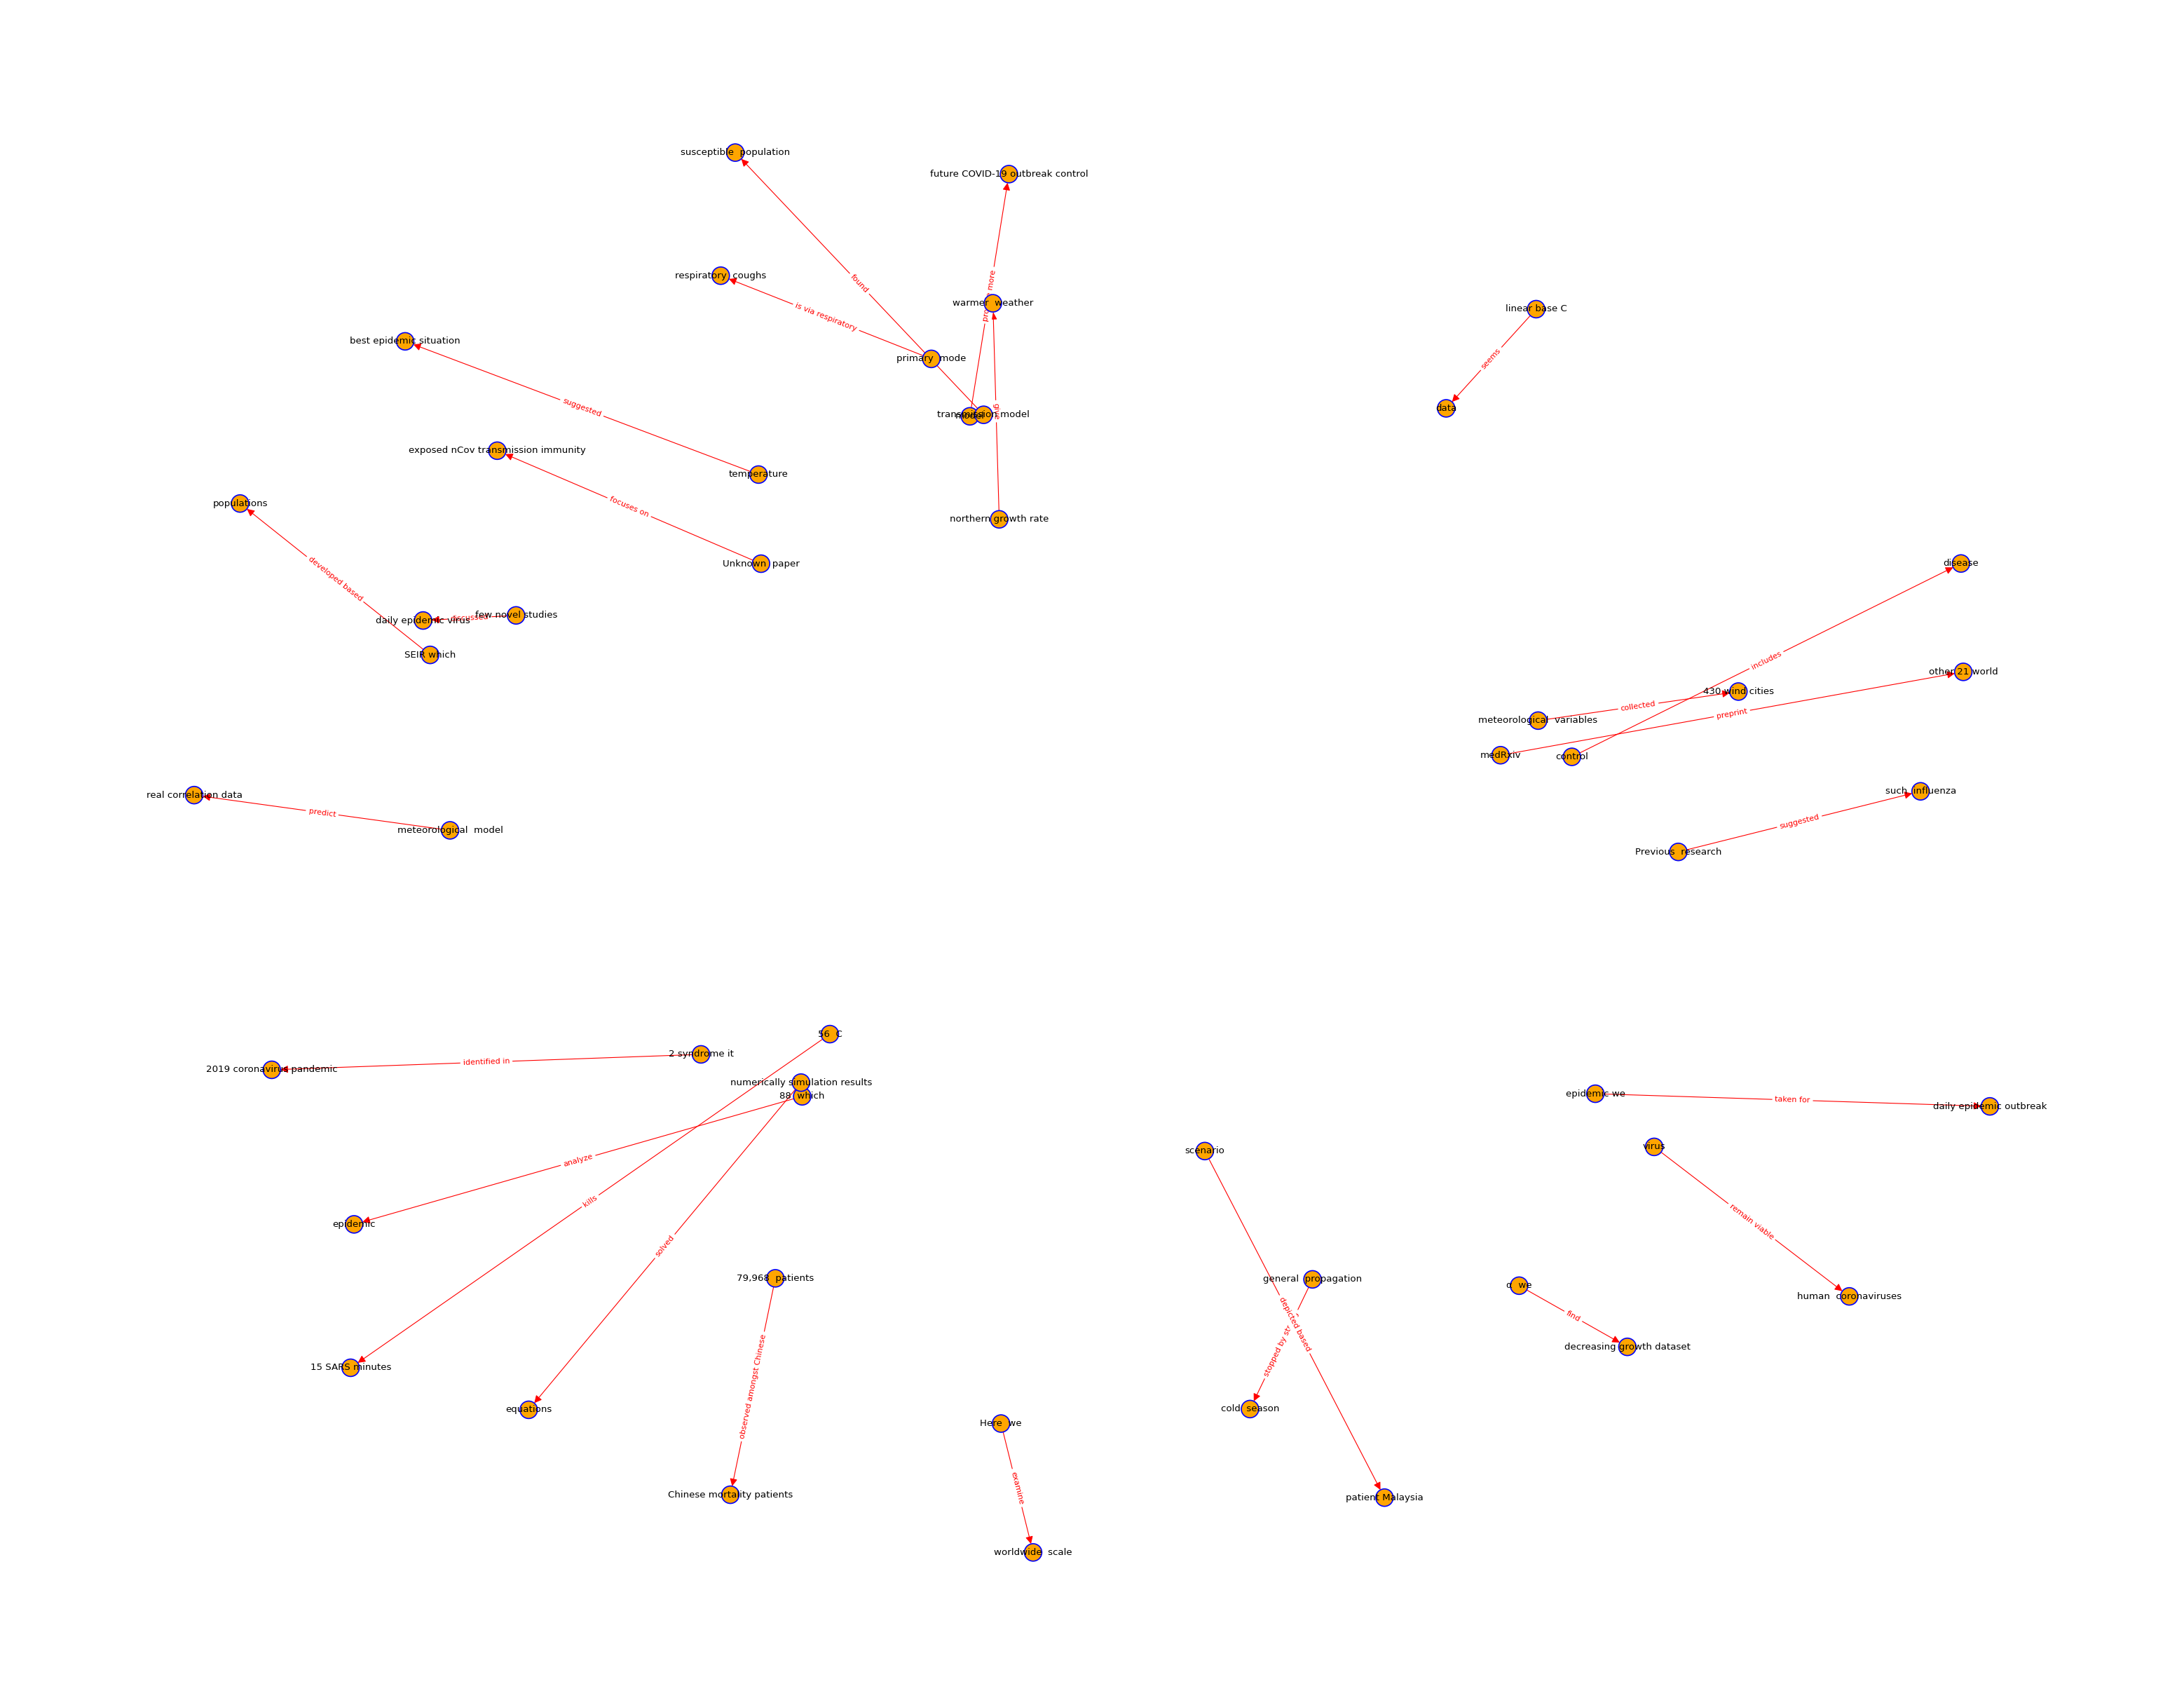

In [32]:
draw_kg(df)

#### Question: What is known about transmission, incubation, and environmental stability?

In [33]:
sentence= "What is known about transmission, incubation, and environmental stability"
similar=get_top_similar(sentence,sentence_list,similarity_matrix,15)

In [34]:
ind,title=list(map(list,zip(*similar)))
titles=[]
texts=[]
for i in ind:
    titles.append(df_cord.iloc[i]['title'])
    texts.append(df_cord.iloc[i]['abstract'])

In [35]:
texts=list(map(clean,texts))
text_list=' '.join(texts)

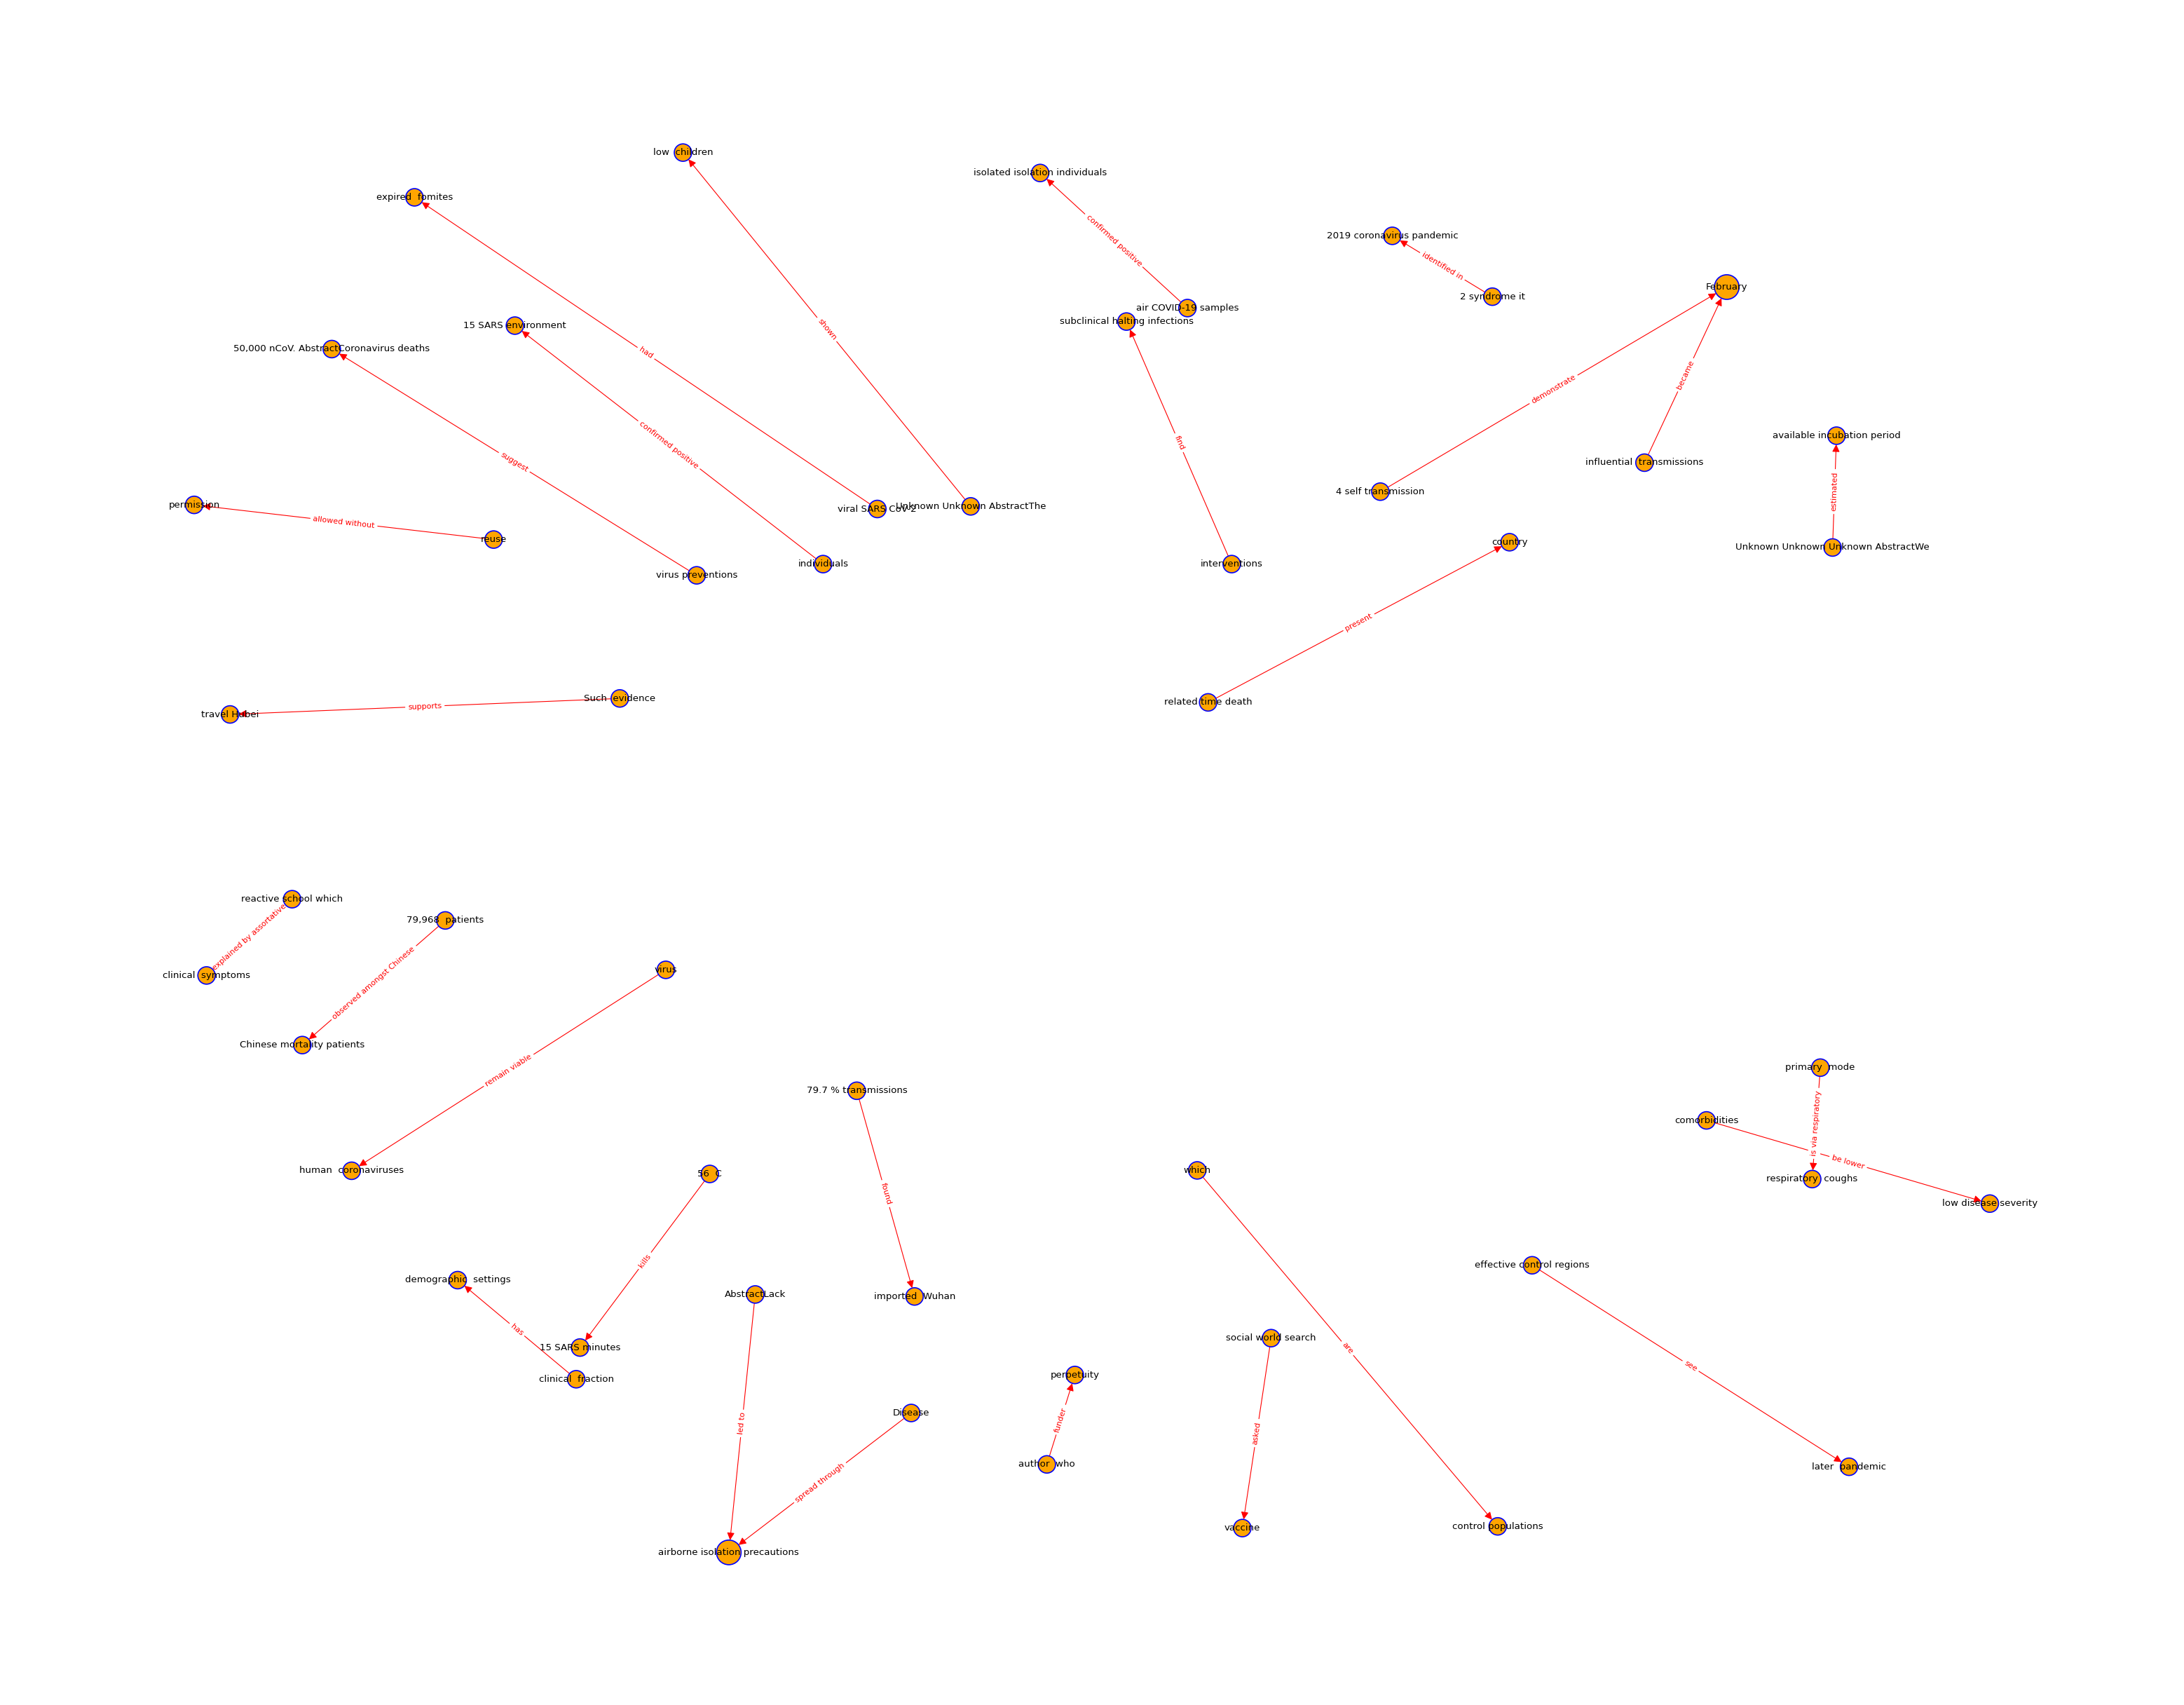

In [36]:
df = prepare_df(text_list)
draw_kg(df)